# Progressive passes

In this notebook, we will create a plot with all the progressive passes by the team.

## Import Packages

In [1]:
import ScraperFC as sfc
import traceback
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from mplsoccer import Pitch, add_image, FontManager, VerticalPitch
from matplotlib.colors import to_rgba
from PIL import Image
from urllib.request import urlopen

## Scrape data from WhoScored

In [2]:
link = 'https://www.whoscored.com/Matches/1558415/Live/France-Ligue-1-2021-2022-Lens-Paris-Saint-Germain'
scraper = sfc.WhoScored()
try:
    match_data = scraper.scrape_match(link)
except:
    traceback.print_exc()
scraper.close()

## Create variables for team names, score and player dictionaries

In this part, we will create variables with general information on the teams, score and players. This will help us in the data visualisation part.

In [4]:
## Get home and away team id and name
home_team = match_data['matchCentreData']['home']['name']
home_id = match_data['matchCentreData']['home']['teamId']

away_team = match_data['matchCentreData']['away']['name']
away_id = match_data['matchCentreData']['away']['teamId']

# Score of the match
score = match_data['matchCentreData']['score']

# Create players dict and dataframes
home_ids = [player['playerId'] for player in match_data['matchCentreData']['home']['players']]
away_ids = [player['playerId'] for player in match_data['matchCentreData']['away']['players']]

players = match_data['matchCentreData']['playerIdNameDictionary']

df_players_home = pd.DataFrame.from_dict(match_data['matchCentreData']['home']['players'])
df_players_away = pd.DataFrame.from_dict(match_data['matchCentreData']['away']['players'])
df_players = pd.concat([df_players_home, df_players_away])

## Data cleaning

Here, we'll clean the dataframe and create another dataframe named df_rel with all the relevant information to create the progressive passes.

In [24]:
#Show all the rows and columns from dataframe
pd.set_option('display.max_columns', None)
#Uncomment this line if we want to see all the rows
pd.set_option("max_rows", None) 

df = pd.DataFrame.from_dict(match_data['matchCentreData']['events'])

df_period = pd.json_normalize(df['period'])
df['period'] = df_period['displayName']

df_type = pd.json_normalize(df['type'])
df['type'] = df_type['displayName']

df_outcomeType = pd.json_normalize(df['outcomeType'])
df['outcomeType'] = df_outcomeType['displayName']

df_qualifiers = pd.json_normalize(match_data['matchCentreData']['events'], record_path=['qualifiers'], meta=['id'])
df_qualifiers = df_qualifiers.pivot(index='id', columns='type.displayName', values='value')
df = df.merge(df_qualifiers, left_on='id', right_on='id')

#Change teamId to team name
df['teamId'] = df['teamId'].apply(lambda x: home_team if x == home_id else away_team)

### Filter out the columns with only relevant data and add player name, shirt No to df
df_rel = df[['id','eventId','minute','second','teamId','x', 'y', 'period', 'type', 'outcomeType', 'playerId', 'endX', 'endY']]
df_rel = df_rel.merge(df_players[['playerId', 'shirtNo', 'name']], how='left')

### Create a column passer and recipient that will be used when we filter by passes
df_rel['passer'] = df_rel['shirtNo']
df_rel['recipient'] = df_rel['shirtNo'].shift(-1)

### Filter dataframe in home and away dataframes
df_home = df_rel[df_rel['teamId'] == home_team]
df_away = df_rel[df_rel['teamId'] == away_team]

## Progressive passes for home team

A progressive pass is a pass made in the attacking 60% of the field that allows to move 25% closer to the goal.
In this part, we'll determine those progressive passes.

We are using Opta data so the goal is located at x = 100 and y = 50. These coordinates are necessary to calculate the distance between the goal and the beginning/ending of a pass.

In [117]:
### Passes by home team and determine if a pass is progressive
h_passes = df_home[df_home['type'] == 'Pass'].reset_index()
h_passes['beginning'] = np.sqrt(np.square(100-h_passes['x'])+np.square(50-h_passes['y']))
h_passes['ending'] = np.sqrt(np.square(100-h_passes['endX'])+np.square(50-h_passes['endY']))
h_passes['progressive'] = [(h_passes['ending'][x] / h_passes['beginning'][x]) < .75 for x in range(len(h_passes.beginning))]

### Filter the progressive passes, successful and unsuccessful passes
#The starting location of a progressive pass must occur 25m after own goal and we exclude corners
h_progressive = h_passes.loc[(h_passes['progressive'] == True) & (h_passes.x > 25) & (h_passes.x < 99.5) & (h_passes.y > 0.5)]
h_prog_succ = h_progressive.loc[h_progressive['outcomeType'] == 'Successful']
h_prog_unsucc = h_progressive.loc[h_progressive['outcomeType'] == 'Unsuccessful']


We'll visualize the progressive passes below. 

Text(0, 1, 'Progressive pass : a pass that moves the ball 25% closer to the goal\nAll progressive passes made 25m after own goal')

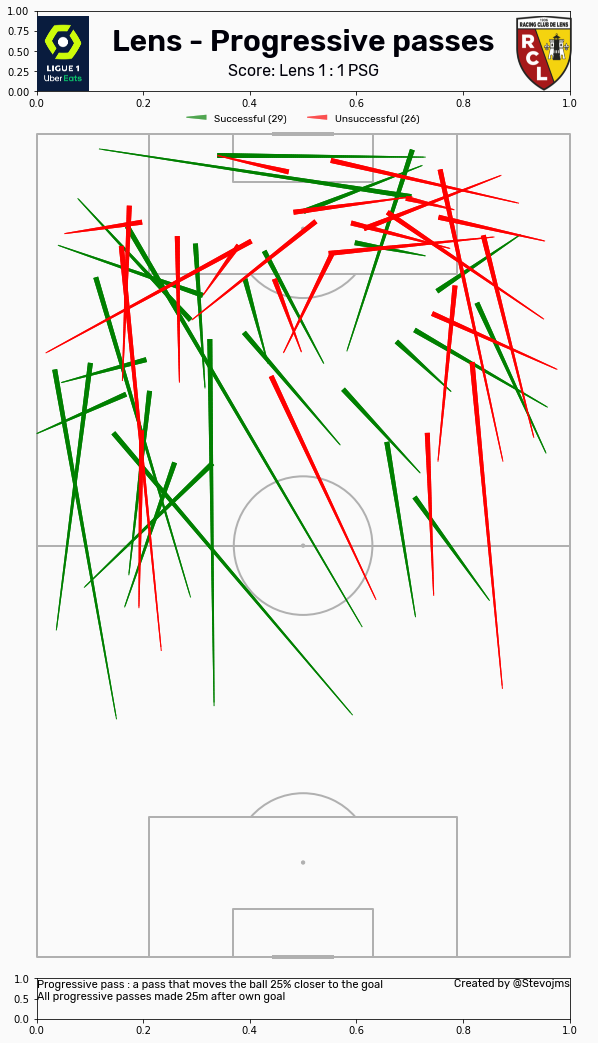

In [118]:
#Pitch visualisation

team_color = '#ec1c24' #Fill in the team color
node_edgecolor = '#fff200'
number_color = '#ffffff'

bgcol = '#fafafa' 
plt.rc('legend',fontsize=20)

URL = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Light.ttf?raw=true'
URL2 = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Regular.ttf?raw=true'
URL3 = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-SemiBold.ttf?raw=true'

rubik_light = FontManager(URL)
rubik_regular = FontManager(URL2)
rubik_semibold = FontManager(URL3)

#Change image URL if needed
COMPETITION_URL = 'https://upload.wikimedia.org/wikipedia/commons/4/49/Ligue1_Uber_Eats_logo.png'
competition_image = Image.open(urlopen(COMPETITION_URL))

#Change team logo URL if needed
team_logo_URL = 'https://www.rclens.fr/sites/default/files/lens.png' #Team logo
team_logo_image = Image.open(urlopen(team_logo_URL))

pitch = VerticalPitch(pitch_type= 'opta', half=False, pad_top = 8)
fig, axs = pitch.grid(figheight=14, title_height=0.08, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_space=0, grid_height=0.88, endnote_height=0.04)

fig.set_facecolor(bgcol)
axs['title'].set_facecolor(bgcol)
axs['pitch'].set_facecolor(bgcol)
axs['endnote'].set_facecolor(bgcol)

prog_pass_succ = pitch.lines(h_prog_succ.x, h_prog_succ.y, h_prog_succ.endX, h_prog_succ.endY, comet=True, color = 'green', ax=axs['pitch'])
prog_pass_unsucc = pitch.lines(h_prog_unsucc.x, h_prog_unsucc.y, h_prog_unsucc.endX, h_prog_unsucc.endY, comet=True, color = 'red', ax=axs['pitch'])

axs['pitch'].legend([prog_pass_succ, prog_pass_unsucc], [f'Successful ({h_prog_succ.x.count()})' , f'Unsuccessful ({h_prog_unsucc.x.count()})'], ncol=2,
                    loc='upper center',
                    bbox_to_anchor=(0.5, 0.985), 
                    prop=rubik_regular.prop,
                    fontsize='medium',
                    facecolor = bgcol,
                    frameon=False)

TITLE = f'{home_team} - Progressive passes'
SUB_TITLE = f'Score: {home_team} {score} {away_team}'
axs['title'].text(0.5, 0.6, TITLE, color='#000009',
                  va='center', ha='center', fontproperties=rubik_semibold.prop, fontsize=30)
axs['title'].text(0.5, 0.25, SUB_TITLE, color='#000009',
                  va='center', ha='center', fontproperties=rubik_regular.prop, fontsize=16)

ax_competition = add_image(competition_image, fig,
                     # set the left, bottom and height to align with the title
                     left=axs['title'].get_position().x0,
                     bottom=axs['title'].get_position().y0,
                     height=axs['title'].get_position().height-0.005)

ax_team_logo = add_image(team_logo_image, fig,
                     # set the left to align with the pitch left border
                     left=0.85,
                     bottom=axs['title'].get_position().y0,
                     height=axs['title'].get_position().height-0.005)

ENDNOTE_LEFT = 'Created by @Stevojms'
ENDNOTE_RIGHT1 = 'Progressive pass : a pass that moves the ball 25% closer to the goal\nAll progressive passes made 25m after own goal'

axs['endnote'].text(1, 1, ENDNOTE_LEFT,
                  va='top', ha='right', fontproperties=rubik_regular.prop, fontsize=11)
axs['endnote'].text(0, 1, ENDNOTE_RIGHT1,
                  va='top', ha='left', fontproperties=rubik_regular.prop, fontsize=11)


## Progressive passes for away team

Below for the calculation and the plot for the away team.

In [127]:
### Passes by home team and determine if a pass is progressive
a_passes = df_away[df_away['type'] == 'Pass'].reset_index()
a_passes['beginning'] = np.sqrt(np.square(100-a_passes['x'])+np.square(50-a_passes['y']))
a_passes['ending'] = np.sqrt(np.square(100-a_passes['endX'])+np.square(50-a_passes['endY']))
a_passes['progressive'] = [(a_passes['ending'][x] / a_passes['beginning'][x]) < .75 for x in range(len(a_passes.beginning))]

### Filter the progressive passes, successful and unsuccessful passes
a_progressive = a_passes.loc[(a_passes['progressive'] == True) & (a_passes.x > 25) & (a_passes.x < 99.5) & (a_passes.y > 0.5)]
a_prog_succ = a_progressive.loc[a_progressive['outcomeType'] == 'Successful']
a_prog_unsucc = a_progressive.loc[a_progressive['outcomeType'] == 'Unsuccessful']

The visualisation for the away team's progressive passes:

Text(0, 1, 'Progressive pass : a pass that moves the ball 25% closer to the goal\nAll progressive passes made 25m after own goal')

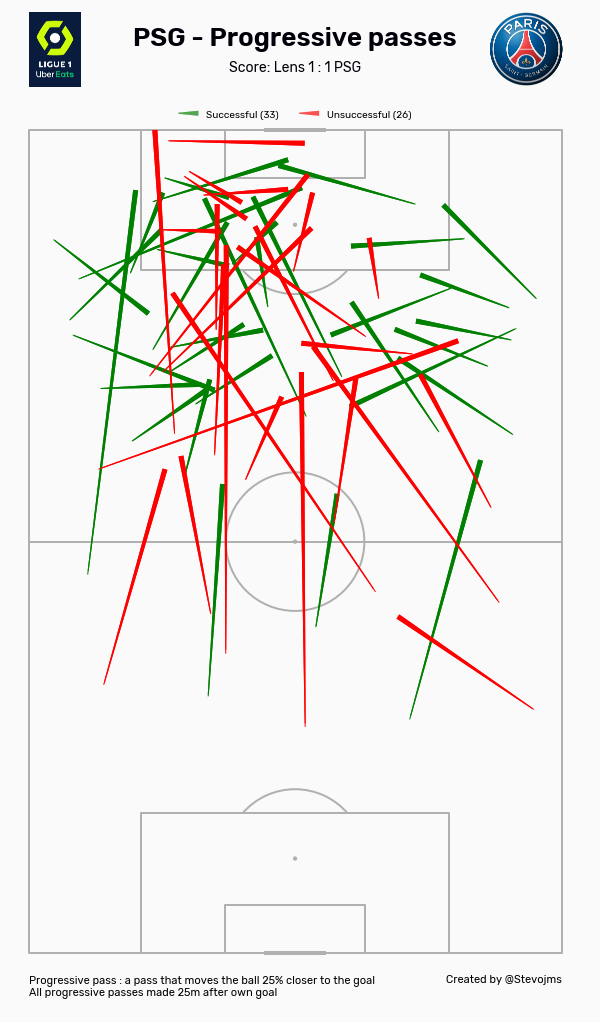

In [128]:
###Pitch visualisation

team_color = '#ec1c24' #Fill in the team color
node_edgecolor = '#fff200'
number_color = '#ffffff'

bgcol = '#fafafa' 
plt.rc('legend',fontsize=20)

URL = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Light.ttf?raw=true'
URL2 = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Regular.ttf?raw=true'
URL3 = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-SemiBold.ttf?raw=true'

rubik_light = FontManager(URL)
rubik_regular = FontManager(URL2)
rubik_semibold = FontManager(URL3)

#Change image URL if needed
COMPETITION_URL = 'https://upload.wikimedia.org/wikipedia/commons/4/49/Ligue1_Uber_Eats_logo.png'
competition_image = Image.open(urlopen(COMPETITION_URL))

#Change team logo URL if needed
team_logo_URL = 'https://logos-world.net/wp-content/uploads/2020/06/PSG-Logo.png' #Team logo
team_logo_image = Image.open(urlopen(team_logo_URL))

pitch = VerticalPitch(pitch_type= 'opta', half=False, pad_top = 8)
fig, axs = pitch.grid(figheight=14, title_height=0.08, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_space=0, grid_height=0.88, endnote_height=0.04)

# Setting up background color (to put in RcParam)
fig.set_facecolor(bgcol)
axs['title'].set_facecolor(bgcol)
axs['pitch'].set_facecolor(bgcol)
axs['endnote'].set_facecolor(bgcol)

# Plotting the successful and unsuccessful passes
prog_pass_succ = pitch.lines(a_prog_succ.x, a_prog_succ.y, a_prog_succ.endX, a_prog_succ.endY, comet=True, color = 'green', ax=axs['pitch'])
prog_pass_unsucc = pitch.lines(a_prog_unsucc.x, a_prog_unsucc.y, a_prog_unsucc.endX, a_prog_unsucc.endY, comet=True, color = 'red', ax=axs['pitch'])

# Adding the legend on top of pitch
axs['pitch'].legend([prog_pass_succ, prog_pass_unsucc], [f'Successful ({a_prog_succ.x.count()})' , f'Unsuccessful ({a_prog_unsucc.x.count()})'], ncol=2,
                    loc='upper center',
                    bbox_to_anchor=(0.5, 0.985), 
                    prop=rubik_regular.prop,
                    fontsize='medium',
                    facecolor = bgcol,
                    frameon=False)

# Plot title and Subtitle
TITLE = f'{away_team} - Progressive passes'
SUB_TITLE = f'Score: {home_team} {score} {away_team}'
axs['title'].text(0.5, 0.6, TITLE, color='#000009',
                  va='center', ha='center', fontproperties=rubik_semibold.prop, fontsize=26)
axs['title'].text(0.5, 0.25, SUB_TITLE, color='#000009',
                  va='center', ha='center', fontproperties=rubik_regular.prop, fontsize=14)

# Adding the competition and team logo
ax_competition = add_image(competition_image, fig,
                     # set the left, bottom and height to align with the title
                     left=axs['title'].get_position().x0,
                     bottom=axs['title'].get_position().y0,
                     height=axs['title'].get_position().height-0.005)

ax_team_logo = add_image(team_logo_image, fig,
                     # set the left to align with the pitch left border
                     left=0.77,
                     bottom=axs['title'].get_position().y0,
                     height=axs['title'].get_position().height-0.005)

# End note texts
ENDNOTE_LEFT = 'Created by @Stevojms'
ENDNOTE_RIGHT1 = 'Progressive pass : a pass that moves the ball 25% closer to the goal\nAll progressive passes made 25m after own goal'

axs['endnote'].text(1, 1, ENDNOTE_LEFT,
                  va='top', ha='right', fontproperties=rubik_regular.prop, fontsize=11)
axs['endnote'].text(0, 1, ENDNOTE_RIGHT1,
                  va='top', ha='left', fontproperties=rubik_regular.prop, fontsize=11)
